## Monk's Problem - SVM

In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve

from utils_monk import read_split_data, abs_path

## Task \#1

### Building the model and training

In [8]:
def model_selection(x, y):

    #Model
    classifier = SVC()

    # List of parameters to try
    SVC_params =  {'kernel' : ['rbf', 'poly', 'sigmoid'], 
              'gamma' : [1, 0.1, 0.01, 0.001],
              'C': [0.1, 1, 10, 100], 
               'class_weight' : [None, 'balanced'],
               'degree' : [2,3]}
    
    # Folds
    folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)
    
    # Grid Search
    SVC_grid = GridSearchCV(estimator=classifier, 
                        param_grid=SVC_params, 
                        n_jobs=2, 
                        cv=folds,
                        scoring = 'accuracy',
                        verbose=2,
                        return_train_score=True)
    
    # Grid results
    grid_results = SVC_grid.fit(x, y)

    means_train = abs(grid_results.cv_results_['mean_train_score'])
    means_test = abs(grid_results.cv_results_['mean_test_score'])
    times_train = grid_results.cv_results_['mean_fit_time']
    times_test = grid_results.cv_results_['mean_score_time']
    params = grid_results.cv_results_['params']

    #for m_ts, t_ts, m_tr, t_tr, p in sorted(zip(means_test, times_test, means_train, times_train, params)):
    #    print("{} \t TR {:.4f} (in {:.4f}) \t TS {:.4f} (in {:.4f})".format(p, m_tr, t_tr, m_ts, t_ts))



    return grid_results.best_params_

In [9]:
def predict(model, x, y):

    y_pred = model.predict(x)

    MSE = mean_squared_error(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return y_pred, MSE, accuracy

In [10]:
def plot_learning_curve(model, x, y, savefig = False):
    p = model.get_params()
    params = dict(kernel=p['kernel'], C=p['C'],
                  gamma=p['gamma'], class_weight = p['class_weight'])
    
    train_sizes, train_scores_svc, test_scores_svc = learning_curve(model, x, y, train_sizes=np.linspace(0.1, 1, 60), n_jobs = 2, cv = 62, verbose=1)

    plt.plot(train_sizes, np.mean(np.abs(train_scores_svc), axis=1))
    plt.plot(train_sizes, np.mean(np.abs(test_scores_svc), axis=1))
    plt.xlabel("train size")
    plt.ylabel("Accuracy")
    plt.legend(['Accuracy TR', 'Accuracy VL'])
    plt.title(f'SVR learning curve \n {params}')

    if savefig:
        plt.savefig("plot\svc_2", transparent = True)

    plt.show()


In [11]:
def modeling_svm():

    # Encoder
    encoder = OneHotEncoder()

    # Getting the path to the file
    data_path_train = abs_path('monks-2.train', 'data')
    data_path_test = abs_path('monks-2.test', 'data')

    # Splitting and encoding the training data
    X_train, y_train = read_split_data(data_path_train)
    X_train = encoder.fit_transform(X_train)

    # Splitting and encoding the test data
    X_test, y_test = read_split_data(data_path_test)
    X_test = encoder.transform(X_test)

    # Finding the best parameters through the grid search
    best_parameters = model_selection(X_train, y_train)
    print("Best parameters: ", best_parameters)

    # Building a model with the best parameters
    svc = SVC(**best_parameters, random_state = 42)

    folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Dividing training set in train and val 
    for train_index, val_index in folds.split(X_train, y_train):
        x_train = X_train[train_index]
        x_val = X_train[val_index]
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]
        
        svc.fit(x_train, y_train_fold)
        
        y_train_pred = svc.predict(x_train)
        y_val_pred = svc.predict(x_val)

        train_losses.append(mean_squared_error(y_train_fold, y_train_pred))
        val_losses.append(mean_squared_error(y_val_fold, y_val_pred))

        train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
        val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    
    # Predicting on test set
    y_test_pred, test_loss, test_accuracy = predict(model = svc, x = X_test, y = y_test)

    print("Training loss: ", np.mean(train_losses))
    print("Validation loss: ", np.mean(val_losses))
    print("Test loss: ", test_loss)

    print("Training accuracy: ", np.mean(train_accuracies))
    print("Validation accuracy: ", np.mean(val_accuracies))
    print("Test accuracy: ", test_accuracy)

    print(classification_report(y_test_pred, y_test))

    plot_learning_curve(svc, X_train, y_train, savefig=True)




Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best parameters:  {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
Training loss:  0.0
Validation loss:  0.023529411764705882
Test loss:  0.0
Training accuracy:  1.0
Validation accuracy:  0.9764705882352942
Test accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432

[learning_curve] Training set sizes: [ 16  19  21  24  26  29  31  34  36  39  41  44  46  49  52  54  57  59
  62  64  67  69  72  74  77  79  82  84  87  90  92  95  97 100 102 105
 107 110 112 115 117 120 122 125 128 130 133 135 138 140 143 145 148 150
 153 155 158 160 163 166]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 3720 out of 3720 | elapsed:   21.4s finished


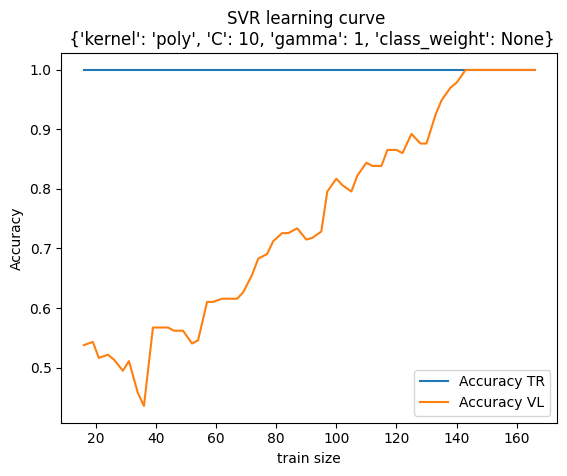

In [12]:
modeling_svm()